In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import math
import msprime
import numpy as np
import pandas as pd
import PTA

pd.set_option('display.max_columns', None)

from collections import OrderedDict
from IPython.display import SVG, display

ipyclient = ipp.Client(cluster_id="PTA")
print(len(ipyclient))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
45


## This is the current best param set (12/13)

In [2]:
# unsorted
model = PTA.DemographicModel("FixingPTA-buff-PriorNe-1000loci")
model.set_param("project_dir", "/tmp")
model.set_param("npops", 9)
model.set_param("nsamps", 8)
# Contemporary Ne from stairway plots
model.set_param("N_e", "2e5-5.5e5")
model.set_param("tau", "1e4-5e5")
model.set_param("epsilon", "0.1")
model.set_param("zeta", 0)
model.set_param("length", "300")
#computationally impractical to simulate 2e4 loci for 20 pops, but this is how you'd do it.
#model.set_param("num_replicates", [nloci_dict[x] for x in expanding_pops])
model.set_param("num_replicates", 1000)
model.set_param("recoms_per_gen", 0)
# Mut rate from manuscript, following Harrington et al 2018
model.set_param("muts_per_gen", 2.2e-9)
print(model.get_params())

model._hackersonly["sorted_sfs"] = True
model._hackersonly["proportional_msfs"] = True
model._hackersonly["tau_buffer"] = 100000
model._hackersonly["Ne_loguniform"] = False
#model._hackersonly["fix_ts"] = 200000
#model.simulate(nsims=50000, quiet=False, verbose=False, ipyclient=ipyclient)

------- PTA params - DemographicModel - (v.0.0.11) -----------------------------
FixingPTA-buff-PriorNe-1000loci ## [0] [simulation_name]: The name of this simulation scenario
/tmp                 ## [1] [project_dir]: Where to save files
9                    ## [2] [npops]: Number of populations undergoing co-demographic processes
8                    ## [3] [nsamps]: Numbers of samples for each populations
200000-550000        ## [4] [N_e]: Effective population size of the contemporary population
10000-500000         ## [5] [tau]: Time of demographic change
0.1                  ## [6] [epsilon]: Magnitude of demographic change
0.0                  ## [7] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
300                  ## [8] [length]: Length in bp of each independent genomic region to simulate
1000,1000,1000,1000,1000,1000,1000,1000,1000 ## [9] [num_replicates]: Number of genomic regions to simulate
1                    ## [10] [generation_time]: Generation t

In [4]:
# The 'reference table'
sorted_sim_df = pd.read_csv("/tmp/FixingPTA-buff-PriorNe-1000loci-SIMOUT.csv", sep=" ")

# Drop zeta_e == 0 (meaningless)
sorted_sim_df = sorted_sim_df[sorted_sim_df.zeta_e > 0]
print(len(sorted_sim_df))
# This is a input
synthetic_community = pd.DataFrame(sorted_sim_df.loc[0]).T.drop(PTA.inference.default_targets, axis=1)

rf_sorted_cl = PTA.inference.Classifier(empirical_df=synthetic_community,
                                       sims=sorted_sim_df,
                                       algorithm="rf")
rf_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'max_depth': 70,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

rf_sorted_cl.set_params(rf_params)
rf_sorted_cl.set_targets(["zeta_e"])
rf_sorted_cl.predict(select_features=False, param_search=False, quick=True, verbose=True)
cv_preds = rf_sorted_cl.cross_val_predict(cv=3, quick=True, verbose=True)

50000
Predict() started: 2023-12-14 13:06:11.404013
Predict() finished: 2023-12-14 13:06:40.625358


/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1050: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1050: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isaac

              precision    recall  f1-score   support

           1       0.26      0.44      0.32      5481
           2       0.22      0.22      0.22      5473
           3       0.18      0.12      0.15      5602
           4       0.20      0.14      0.16      5475
           5       0.20      0.14      0.17      5427
           6       0.22      0.20      0.21      5607
           7       0.27      0.26      0.26      5728
           8       0.32      0.28      0.30      5641
           9       0.51      0.75      0.61      5566

    accuracy                           0.28     50000
   macro avg       0.26      0.28      0.27     50000
weighted avg       0.26      0.28      0.27     50000



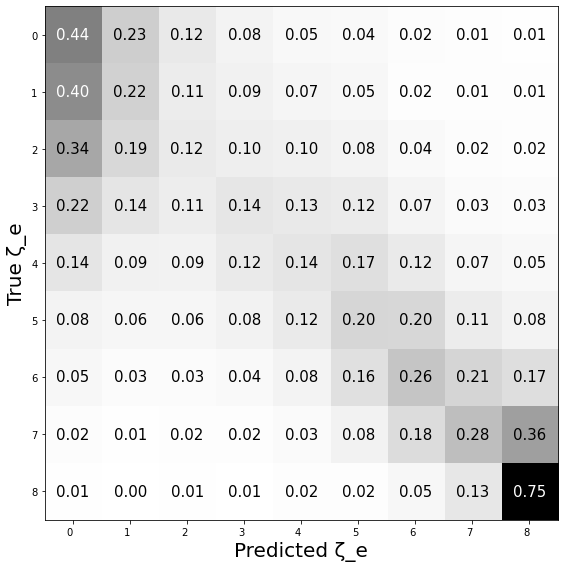

In [7]:
ax = rf_sorted_cl.plot_confusion_matrix(normalize=True)

In [8]:
%%time
# Load msfs and reshape it into a format the ML stuff expects
sorted_expanding_msfs = pd.read_csv("/home/isaac/proj/Islands2030/PTA-GalapagosGeckos/analysis/msfs/Expanding-proj8-sort-props.msfs", index_col=0)
sorted_expanding_msfs = pd.DataFrame(sorted_expanding_msfs.to_numpy().ravel(order="F"), index=synthetic_community.columns).T
display(sorted_expanding_msfs)

rf_sorted_cl.set_data(sorted_expanding_msfs)
rf_class_est = rf_sorted_cl.predict(select_features=False,\
                                    param_search=False,\
                                    quick=True,\
                                    verbose=True)
#axs = gb_sorted_cl.plot_feature_importance()
rf_class_est

,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]],pop3-[[7_1]],pop3-[[6_2]],pop3-[[5_3]],pop3-[[4_4]],pop4-[[7_1]],pop4-[[6_2]],pop4-[[5_3]],pop4-[[4_4]],pop5-[[7_1]],pop5-[[6_2]],pop5-[[5_3]],pop5-[[4_4]],pop6-[[7_1]],pop6-[[6_2]],pop6-[[5_3]],pop6-[[4_4]],pop7-[[7_1]],pop7-[[6_2]],pop7-[[5_3]],pop7-[[4_4]],pop8-[[7_1]],pop8-[[6_2]],pop8-[[5_3]],pop8-[[4_4]]
0,0.748994,0.227795,0.158181,0.069528,0.669777,0.219819,0.137826,0.064843,0.65411,0.219751,0.129205,0.061477,0.617756,0.212706,0.128638,0.058646,0.610637,0.203757,0.114924,0.048039,0.596941,0.194032,0.11353,0.047568,0.593813,0.19033,0.108528,0.047225,0.592331,0.190137,0.096651,0.03954,0.581962,0.157883,0.067235,0.025889


Predict() started: 2023-12-14 13:17:31.631485
CPU times: user 1.08 s, sys: 329 ms, total: 1.41 s
Wall time: 1.21 s


(          zeta_e
 estimate       2,
                1        2         3         4         5         6         7  \
 zeta_e  0.193425  0.22217  0.217436  0.154189  0.099236  0.051982  0.034004   
 
                8         9  
 zeta_e  0.018823  0.008735  )

Removed invariant targets. Retained: ['t_s', 'omega', 'taus_mean']
Predict() started: 2023-12-14 14:12:04.977409
Predict() finished: 2023-12-14 14:12:10.419760


/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

                     MAE         RMSE    vscore        R2
t_s        132388.011413  1499.511921  0.288874  0.288858
taus_mean   35787.046737   422.355015  0.431165  0.431151
taus_std    14837.624011   177.783228  0.203503  0.203478
CPU times: user 4min 26s, sys: 15.6 s, total: 4min 41s
Wall time: 31.4 s


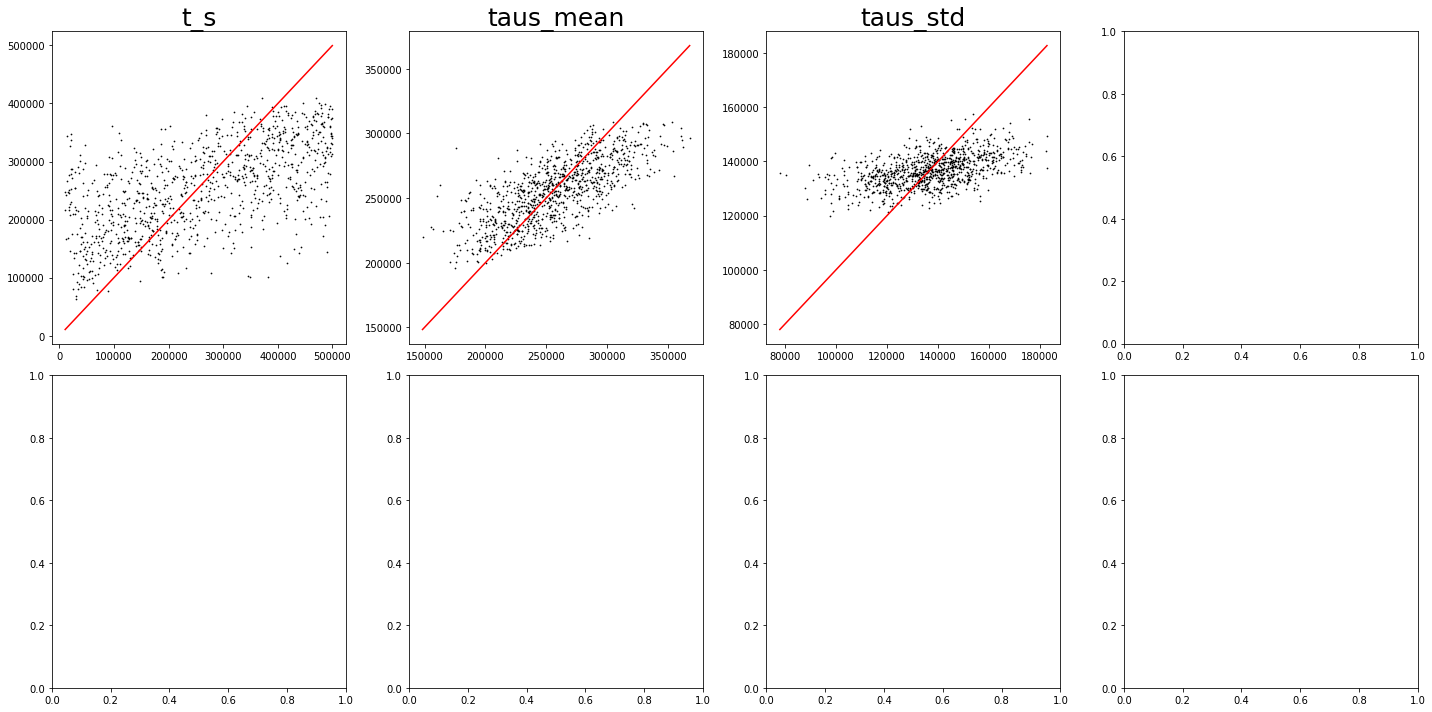

In [15]:
%%time
pruned_sorted_df = sorted_sim_df[sorted_sim_df["zeta_e"].between(2, 3)]
rf_rgr = PTA.inference.Regressor(empirical_df=synthetic_community,\
                                sims=pruned_sorted_df,\
                                algorithm="rf",\
                                verbose=True)
rf_rgr.set_params(rf_params)
rf_rgr.set_targets(["t_s", "taus_mean", "taus_std"])
rf_rgr.predict(select_features=False,\
            param_search=False,\
            quick=False,\
            verbose=True)
rg_rgr_preds = rf_rgr.cross_val_predict(verbose=True)
ax = rf_rgr.plot_cv_predictions(figsize=(20,10), figdims=(2,4))

In [16]:
rf_param_est = rf_rgr.predict(sorted_expanding_msfs)
rf_param_est

,t_s,taus_mean,taus_std
estimate,382761.999998,298084.834291,134774.731801


In [19]:
import numpy as np
def pred_ints(model, X, percentile=95):
    preds = []
    err_down = []
    err_up = []
    for pred in model.best_model.estimators_:
        preds.append(pred.predict(X))
        err_down = np.percentile(preds, (100 - percentile) / 2. , axis=0)[0]
        err_up = np.percentile(preds, 100 - (100 - percentile) / 2., axis=0)[0]
    return err_down, err_up

err_down, err_up = pred_ints(rf_rgr, sorted_expanding_msfs, percentile=95)
pred_intervals = pd.DataFrame(np.array([err_down, rf_param_est.values[0], err_up]), columns=rf_param_est.columns)
pred_intervals

,t_s,taus_mean,taus_std
0,31993.000000,184826.759225,119101.372467
1,382761.999998,298084.834291,134774.731801
2,387916.041667,266455.601840,158234.930325


(array([121., 228., 157., 133., 109.,  84.,  89.,  63.,  65.,  58.,  56.,
         59.,  42.,  45.,  31.,  26.,  17.,  11.,   3.,   3.]),
 array([ 16690.        ,  38589.07142857,  60488.14285714,  82387.21428571,
        104286.28571429, 126185.35714286, 148084.42857143, 169983.5       ,
        191882.57142857, 213781.64285714, 235680.71428571, 257579.78571429,
        279478.85714286, 301377.92857143, 323277.        , 345176.07142857,
        367075.14285714, 388974.21428571, 410873.28571429, 432772.35714286,
        454671.42857143]),
 <BarContainer object of 20 artists>)

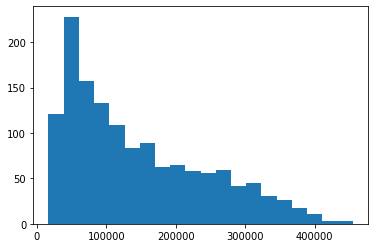

In [12]:
def pred_ints(model, X):
    preds = []
    err_down = []
    err_up = []
    p = np.linspace(0, 100, 10)
    for pred in model.best_model.estimators_:
        preds.append(pred.predict(X))
    percentiles = np.percentile(preds, p, axis=0)[0]
    return preds
_preds = pred_ints(rf_rgr, sorted_expanding_msfs)
#plt.plot(np.percentile(_preds, np.linspace(0, 100, 10), axis=0)[:, :, 0])
plt.hist(np.array(_preds)[:, :, 0], bins=20)

In [146]:
sorted_sim_df[["zeta_e", "t_s", "pop0-[[7_1]]", "pop0-[[6_2]]", "pop0-[[5_3]]", "pop0-[[4_4]]", "pop1-[[7_1]]"]].head(1000)

,zeta_e,t_s,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]]
0,3,200000.0,0.678,0.238,0.155,0.065,0.658
1,2,200000.0,0.686,0.235,0.140,0.061,0.633
2,3,200000.0,0.661,0.235,0.138,0.053,0.631
3,2,200000.0,0.665,0.236,0.144,0.061,0.641
4,7,200000.0,0.671,0.242,0.163,0.064,0.670
...,...,...,...,...,...,...,...
995,1,200000.0,0.665,0.246,0.156,0.076,0.656
996,7,200000.0,0.667,0.225,0.132,0.055,0.665
997,7,200000.0,0.667,0.234,0.131,0.055,0.666
998,2,200000.0,0.650,0.233,0.159,0.070,0.634
